In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [1]:
import statsmodels.api as sm

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


In [3]:
type(ratings)

scipy.sparse.lil.lil_matrix

### Plot the number of ratings per movie and user

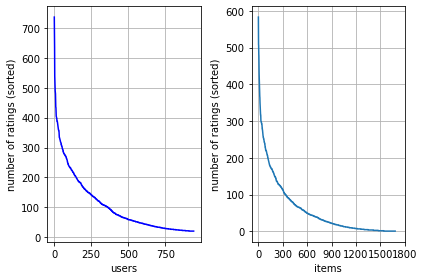

min # of items per user = 20, min # of users per item = 1.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [5]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(9)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    train = valid_ratings.copy()
    test = valid_ratings.copy()
    train_indices = np.random.binomial(1, 0.9, valid_ratings.shape)
    train[train_indices == 0] = 0 
    test[~(train_indices == 0)] = 0
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88247
Total number of nonzero elements in test data:9705


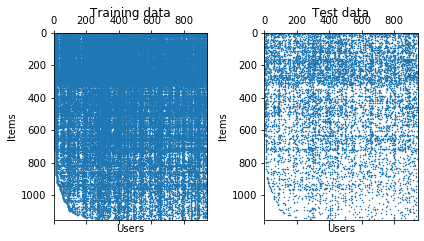

In [6]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [8]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************    
    mean = train.mean()
    return np.sqrt((1/2)*calculate_mse(test[test.nonzero()].toarray(), mean)/test.count_nonzero())

baseline_global_mean(train, test)

array([[2.43413159]])

In [27]:
from scipy.sparse import lil_matrix
A = lil_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5]])
print(A[A.nonzero()])

  (0, 0)	1
  (0, 1)	2
  (0, 2)	3
  (0, 3)	4
  (0, 4)	5



### Use the user means as the prediction

In [11]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    means = train.mean(axis=0)
    total_mse = 0
    total_rated_movies = 0
    for i in range(num_users):
        user_ratings = test[:,i]
        total_rated_movies += user_ratings.count_nonzero()
        #if nb_ratings != 0:
        user_mse = calculate_mse(user_ratings[user_ratings.nonzero()].toarray(), means[:,i])
        total_mse += user_mse#/ user_ratings.count_nonzero()
    return np.sqrt((1/2)* (total_mse / total_rated_movies))

baseline_user_mean(train, test)

matrix([[2.2924849]])

### Use the item means as the prediction

In [13]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    means = train.mean(axis=1)
    total_mse = 0
    total_rated_movies = 0
    for i in range(num_items):
        item_ratings = test[i,:]
        total_rated_movies += item_ratings.count_nonzero()
        #if nb_ratings != 0:
        item_mse = calculate_mse(item_ratings[item_ratings.nonzero()].toarray(), means[i,:])
        total_mse += item_mse 
    return np.sqrt((1/2) * total_mse / total_rated_movies)
    
baseline_item_mean(train, test)

matrix([[2.22216799]])

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [15]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    num_item, num_user = train.shape
    return np.ones((num_user, num_features)), np.ones((num_item, num_features))
    

Compute the cost by the method of matrix factorization.


In [16]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    data_appr = item_features @ user_features.T
    non_zero_indexes = data.nonzero()
    mse = calculate_mse(data[non_zero_indexes], data_appr[non_zero_indexes])
    return np.sqrt(mse / (2*len(nz)))

In [28]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.9
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1
        
        for d, n in nz_train:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
            #print(f'n : {n}, d: {d}, item_shape: {item_features.shape}, user_shape: {user_features.shape}')
            x_dn = train[d, n]
            w_d = item_features[d, :]
            z_n = user_features[n, :]
            sign = -np.sign(x_dn - w_d @ z_n.T)
            w_d_new = w_d.copy()
            z_n_new = z_n.copy()
            w_d_new = w_d * sign * (2 ** (-1/2))
            z_n_new = z_n * sign * (2 ** (-1/2))
            item_features[d,:] = w_d - gamma * w_d_new
            user_features[n,:] = z_n - gamma * z_n_new
        
       # print(item_features[:20])
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: [[2.83323816]].
iter: 1, RMSE on training set: [[2.62542309]].
iter: 2, RMSE on training set: [[2.86208924]].
iter: 3, RMSE on training set: [[2.90679867]].
iter: 4, RMSE on training set: [[3.13668338]].
iter: 5, RMSE on training set: [[2.97094001]].
iter: 6, RMSE on training set: [[2.72764001]].
iter: 7, RMSE on training set: [[3.08476296]].
iter: 8, RMSE on training set: [[3.08301786]].
iter: 9, RMSE on training set: [[2.9587673]].
iter: 10, RMSE on training set: [[2.7199256]].
iter: 11, RMSE on training set: [[3.00782444]].
iter: 12, RMSE on training set: [[2.80531691]].
iter: 13, RMSE on training set: [[2.96052338]].
iter: 14, RMSE on training set: [[3.06380088]].
iter: 15, RMSE on training set: [[2.92648672]].
iter: 16, RMSE on training set: [[3.16018852]].
iter: 17, RMSE on training set: [[2.80346312]].
iter: 18, RMSE on training set: [[2.73090826]].
iter: 19, RMSE on training set: [[3.00614393]].
RMSE on 

In [ ]:
a = np.arange(5)
b = a[2:4]
b[0] = 100
display(a)
b

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)